In [ ]:
!pip install GPy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 959 kB 5.2 MB/s 
     |████████████████████████████████| 71 kB 5.2 MB/s 
  Created wheel for GPy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2565088 sha256=25d61d9e16c3d3b787ce64bc7f5240b2583e8e93ef067f63a2ce59bd67b545e7
  Stored in directory: /root/.cache/pip/wheels/f7/18/28/dd1ce0192a81b71a3b086fd952511d088b21e8359ea496860a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102566 sha256=78036800bc7fd6d89e312f81657e75fa95af04aabf4feccb19757558eeae1ed6
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built GPy paramz


In [ ]:
import GPy
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from tqdm import tqdm

In [ ]:
class TargetPrior():
  
  def __init__(self, d_cardinal=1000):
    self.d_cardinal = d_cardinal
    self.X = np.linspace(0, 1, self.d_cardinal)[:, None]

    self.mu = np.zeros(self.d_cardinal)
    self.k = GPy.kern.RBF(1)
    self.k.lengthscale = 0.2

    self.C = self.k.K(self.X, self.X)

    self.Y = np.random.multivariate_normal(self.mu, self.C, 1)[0]
  
  def sample(self, x):
    return self.Y[int(np.unique(x))]
    #return np.sin(x)
  
  def sample_noisy(self, x):
    return self.sample(x) + np.random.normal(0, 0)
  
  def best_action(self):
    return np.argmax(self.Y)
  
  def best_reward(self):

    best_action_idx = self.best_action()
    return self.sample_noisy(best_action_idx)

In [ ]:
class GPUCB():

  def __init__(self, target, rounds=50, delta=0.1, d_cardinal=1000):

    self.target = target
    self.d_cardinal = d_cardinal
    self.interval = np.linspace(0, 1, self.d_cardinal)[:, None]

    self.X = np.zeros(rounds)[:, None]
    self.Y = np.zeros(rounds)[:, None]

    self.regrets = np.zeros(rounds)

    self.beta = None
    self.delta = delta
    
    self.kernel = GPy.kern.RBF(1)
    self.kernel.lengthscale = 0.2
    self.kernel.fix()

    self.mu = np.zeros(self.interval.size)
    self.sigma = np.ones(self.interval.size)/2

    self.round = 1
    self.rounds = rounds
  
  def update(self, plotting=False):
    
    # Choose optimal exploration parameter (Theorem 1)
    self.beta = 2*np.log(self.d_cardinal*(self.round**2)*(np.pi**2)/(6*self.delta))

    # Choose an action according to the exploration parameter
    action_idx = np.argmax(self.mu + np.sqrt(self.beta)*self.sigma)
    action = self.interval[action_idx]

    # Get noisy feedback
    reward = self.target.sample_noisy(action_idx)

    # Store for Bayesian update
    self.X[self.round-1] = action
    self.Y[self.round-1] = reward

    # GP Regression
    gp_model = GPy.models.GPRegression(self.X[:self.round], self.Y[:self.round], self.kernel)
    gp_model.optimize()

    # Update parameters
    self.mu, var = gp_model.predict(self.interval)
    self.sigma = np.sqrt(var)

    # Compute regret for this round
    best_reward = self.target.best_reward()
    regret = best_reward - reward

    # Store regret
    self.regrets[self.round-1] = regret

    if plotting:
      self.plot(self.X[:self.round], self.Y[:self.round])

    # Proceed to the next round
    self.round += 1
  
  def train(self, update_plot=False, train_plot=True, no_print=True):

    for i in tqdm(range(self.rounds), disable=no_print):
      self.update(update_plot)
    
    if train_plot:
      self.plot(self.X, self.Y)

  
  def plot(self, X, Y):

    plt.figure()
    plt.plot(self.target.X, self.target.Y)
    plt.plot(X, Y, "ro")
    plt.show()


In [ ]:
def reproducibility(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

  0%|          | 0/50 [00:00<?, ?it/s]

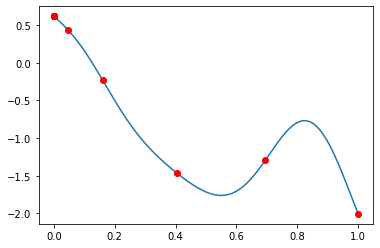

  2%|▏         | 1/50 [00:06<04:57,  6.07s/it]

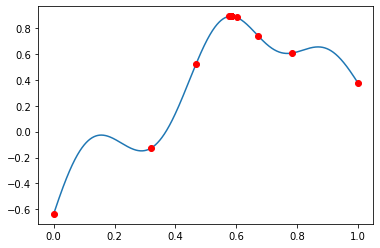

  4%|▍         | 2/50 [00:11<04:47,  5.98s/it]

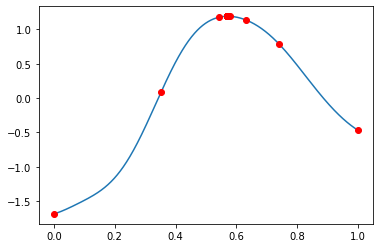

  6%|▌         | 3/50 [00:17<04:41,  5.98s/it]

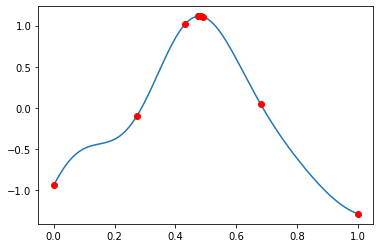

  8%|▊         | 4/50 [00:23<04:34,  5.97s/it]

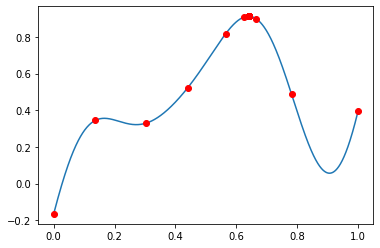

 10%|█         | 5/50 [00:29<04:28,  5.98s/it]

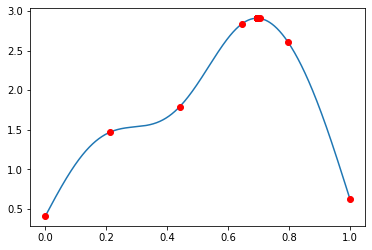

 12%|█▏        | 6/50 [00:35<04:22,  5.96s/it]

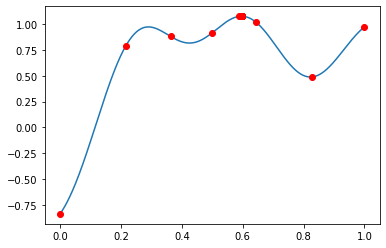

 14%|█▍        | 7/50 [00:41<04:16,  5.96s/it]

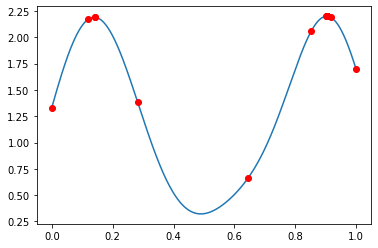

 16%|█▌        | 8/50 [00:47<04:09,  5.95s/it]

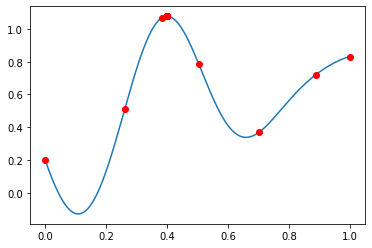

 18%|█▊        | 9/50 [00:55<04:28,  6.55s/it]

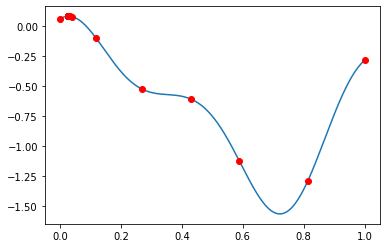

 20%|██        | 10/50 [01:01<04:15,  6.39s/it]

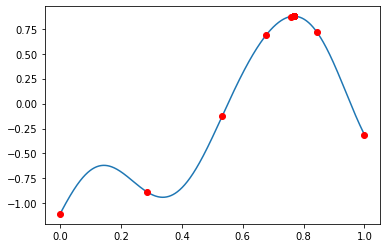

 22%|██▏       | 11/50 [01:07<04:03,  6.25s/it]

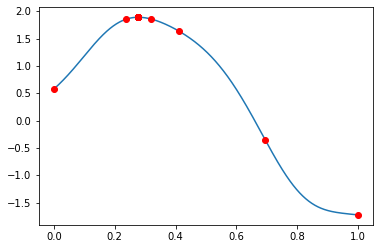

 24%|██▍       | 12/50 [01:15<04:17,  6.76s/it]

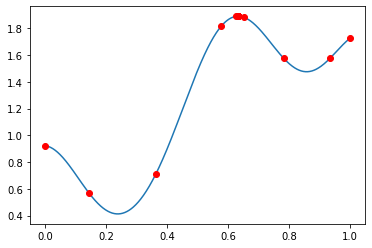

 26%|██▌       | 13/50 [01:21<04:02,  6.54s/it]

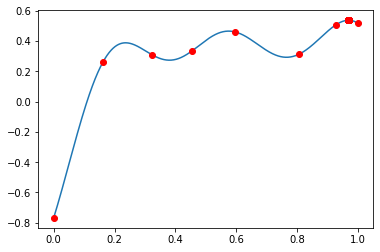

 28%|██▊       | 14/50 [01:27<03:49,  6.36s/it]

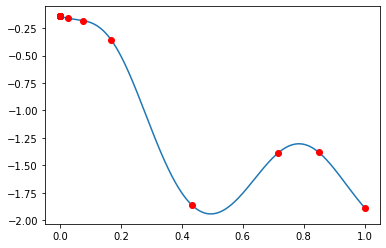

 30%|███       | 15/50 [01:33<03:37,  6.21s/it]

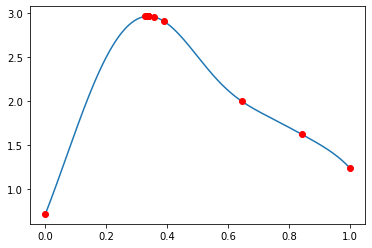

 32%|███▏      | 16/50 [01:39<03:27,  6.11s/it]

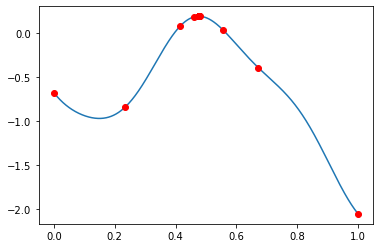

 34%|███▍      | 17/50 [01:45<03:20,  6.08s/it]

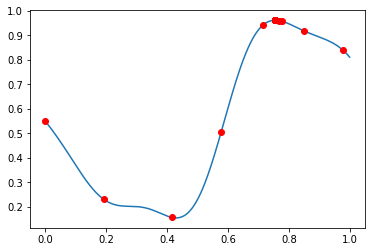

 36%|███▌      | 18/50 [01:51<03:13,  6.06s/it]

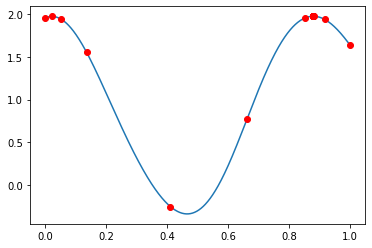

 38%|███▊      | 19/50 [01:57<03:08,  6.09s/it]

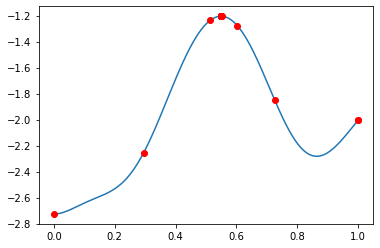

 40%|████      | 20/50 [02:03<02:59,  6.00s/it]

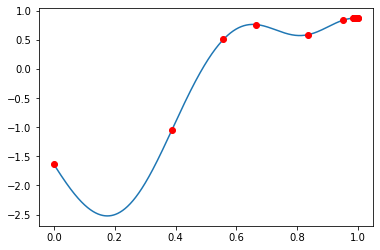

 42%|████▏     | 21/50 [02:09<02:52,  5.95s/it]

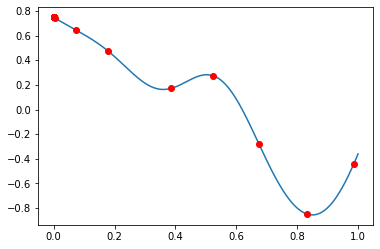

 44%|████▍     | 22/50 [02:14<02:46,  5.93s/it]

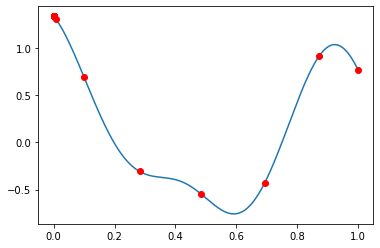

 46%|████▌     | 23/50 [02:20<02:38,  5.89s/it]

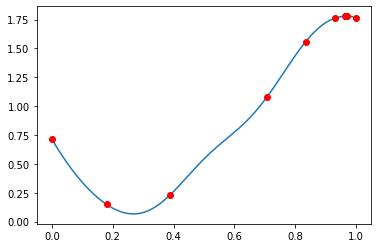

 48%|████▊     | 24/50 [02:26<02:33,  5.92s/it]

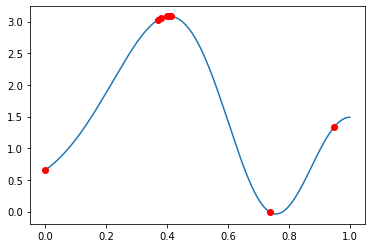

 50%|█████     | 25/50 [02:32<02:27,  5.91s/it]

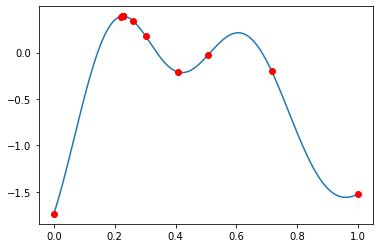

 52%|█████▏    | 26/50 [02:38<02:20,  5.87s/it]

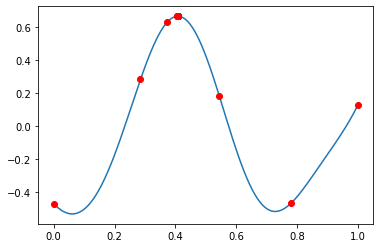

 54%|█████▍    | 27/50 [02:44<02:15,  5.89s/it]

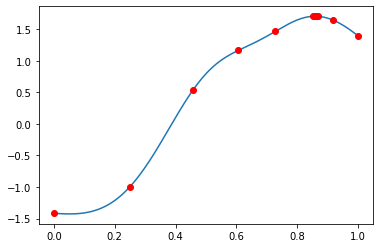

 56%|█████▌    | 28/50 [02:50<02:10,  5.92s/it]

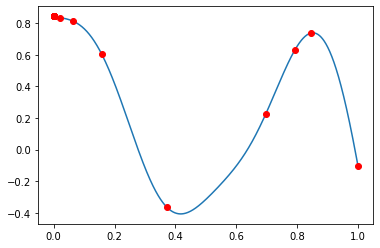

 58%|█████▊    | 29/50 [02:56<02:04,  5.95s/it]

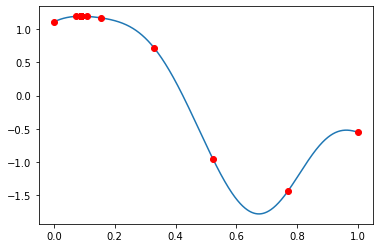

 60%|██████    | 30/50 [03:02<01:59,  5.98s/it]

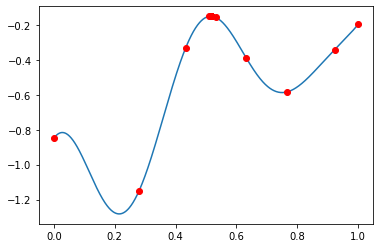

 62%|██████▏   | 31/50 [03:10<02:04,  6.57s/it]

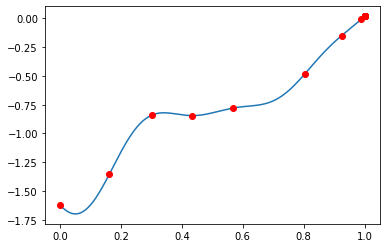

 64%|██████▍   | 32/50 [03:16<01:54,  6.37s/it]

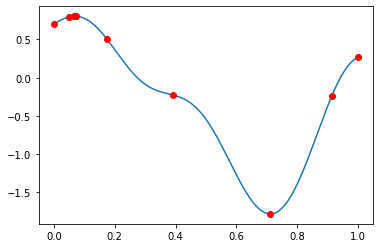

 66%|██████▌   | 33/50 [03:22<01:45,  6.23s/it]

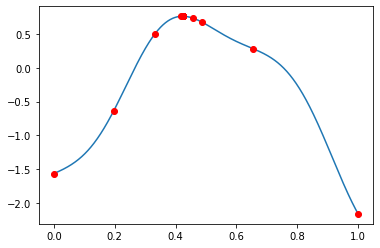

 68%|██████▊   | 34/50 [03:27<01:37,  6.07s/it]

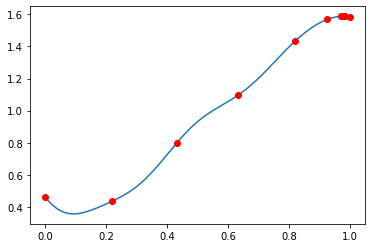

 70%|███████   | 35/50 [03:33<01:30,  6.01s/it]

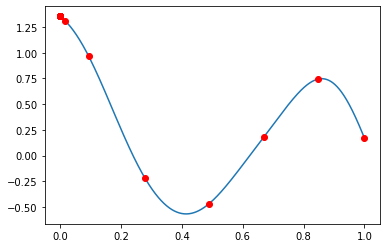

 72%|███████▏  | 36/50 [03:39<01:23,  5.96s/it]

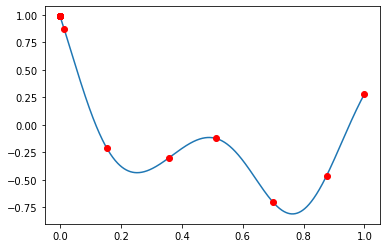

 74%|███████▍  | 37/50 [03:45<01:17,  5.96s/it]

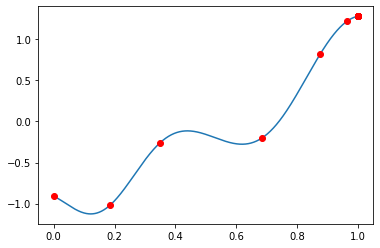

 76%|███████▌  | 38/50 [03:51<01:11,  6.00s/it]

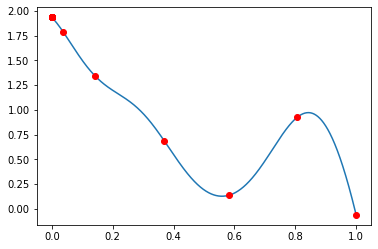

 78%|███████▊  | 39/50 [03:57<01:05,  5.98s/it]

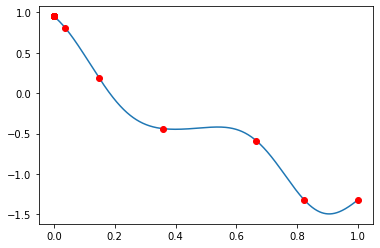

 80%|████████  | 40/50 [04:03<00:59,  6.00s/it]

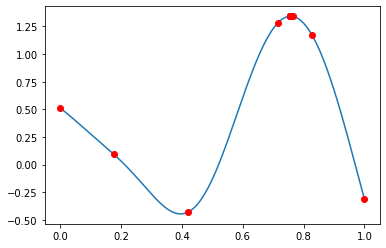

 82%|████████▏ | 41/50 [04:09<00:54,  6.09s/it]

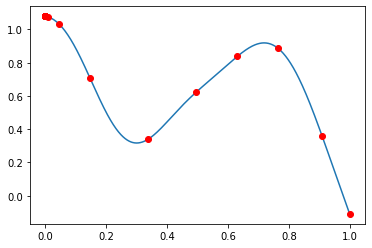

 84%|████████▍ | 42/50 [04:16<00:49,  6.18s/it]

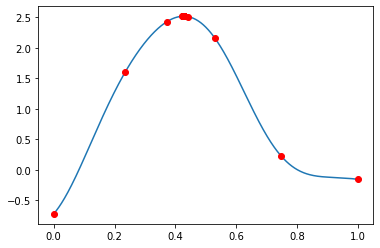

 86%|████████▌ | 43/50 [04:22<00:43,  6.21s/it]

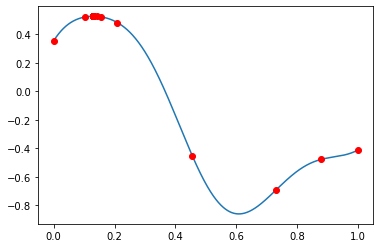

 88%|████████▊ | 44/50 [04:28<00:36,  6.14s/it]

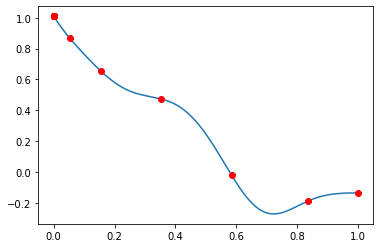

 90%|█████████ | 45/50 [04:34<00:30,  6.08s/it]

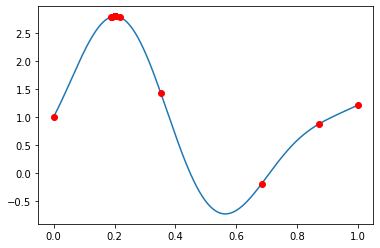

 92%|█████████▏| 46/50 [04:40<00:24,  6.04s/it]

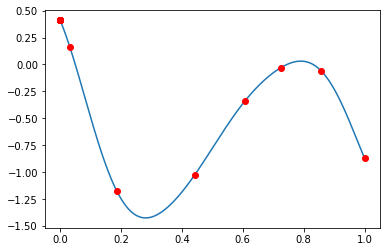

 94%|█████████▍| 47/50 [04:46<00:18,  6.06s/it]

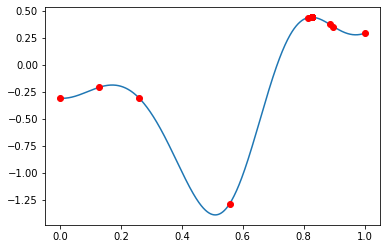

 96%|█████████▌| 48/50 [04:52<00:12,  6.05s/it]

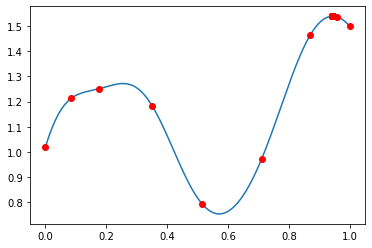

 98%|█████████▊| 49/50 [04:58<00:06,  6.07s/it]

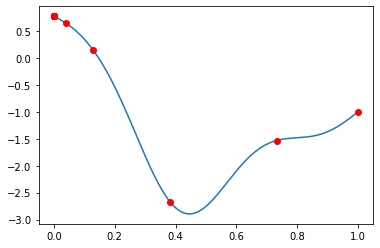

100%|██████████| 50/50 [05:06<00:00,  6.14s/it]


ValueError: ignored

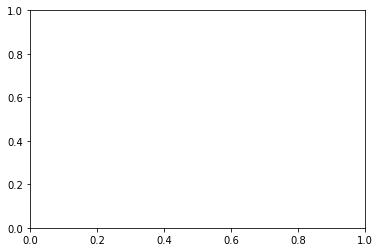

In [ ]:
rounds = 100
experiments = 50

regrets = np.zeros(rounds)

reproducibility(1)

for i in tqdm(range(experiments), disable=False):
  target = TargetPrior()
  gp_agent = GPUCB(target, rounds=100)
  gp_agent.train()
  regrets += gp_agent.regrets

regrets /= experiments

plt.figure()
plt.plot(np.arange(rounds), regrets)

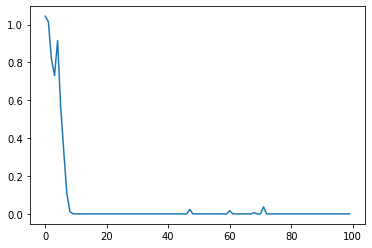

In [ ]:
plt.figure()
plt.plot(np.arange(rounds), regrets)

In [ ]:
target = TargetPrior()

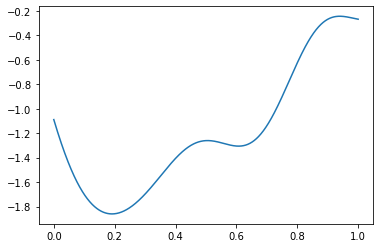

In [ ]:
plt.plot(np.linspace(0, 1, 1000), target.Y)

In [ ]:
gp_agent = GPUCB(target)

100%|██████████| 50/50 [00:03<00:00, 14.54it/s]


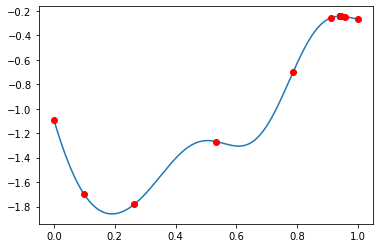

In [ ]:
gp_agent.train()

In [ ]:
gp_agent.Y

array([[-1.08855314],
       [-0.26691461],
       [-1.26892429],
       [-1.78233264],
       [-0.70213873],
       [-0.25495979],
       [-0.24285441],
       [-0.24554115],
       [-0.24263255],
       [-0.24263255],
       [-0.24263255],
       [-0.24263255],
       [-0.24263255],
       [-0.24263255],
       [-0.24263255],
       [-0.24263255],
       [-0.24263255],
       [-0.24263255],
       [-0.24262866],
       [-0.24262866],
       [-0.24262866],
       [-0.24262866],
       [-0.24262866],
       [-0.24262866],
       [-0.24262866],
       [-0.24262866],
       [-0.24262866],
       [-0.24262866],
       [-0.24263255],
       [-0.24262866],
       [-0.24262866],
       [-0.24262866],
       [-0.24262866],
       [-1.70140504],
       [-0.24262866],
       [-0.24262866],
       [-0.24262866],
       [-0.24262866],
       [-0.24262866],
       [-0.24262866],
       [-0.24262866],
       [-0.24262866],
       [-0.24262866],
       [-0.24263255],
       [-0.24262866],
       [-0

In [ ]:
gp_agent.regrets

array([8.45924479e-01, 2.42859530e-02, 1.02629564e+00, 1.53970399e+00,
       4.59510074e-01, 1.23311351e-02, 2.25758349e-04, 2.91249685e-03,
       3.88962535e-06, 3.88962535e-06, 3.88962535e-06, 3.88962535e-06,
       3.88962535e-06, 3.88962535e-06, 3.88962535e-06, 3.88962535e-06,
       3.88962535e-06, 3.88962535e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.88962535e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.45877638e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.88962535e-06,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.88962535e-06])